In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd

In [5]:
dataf = pd.read_csv('/content/drive/MyDrive/age_gender.csv')

In [6]:
dataf.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [7]:
import keras
import json
import sys
import tensorflow as tf
from keras.layers import Input
import numpy as np
import argparse
#from keras_applications.resnext import ResNeXt50
from keras.utils import get_file
#import face_recognition

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

(-0.5, 47.5, 47.5, -0.5)

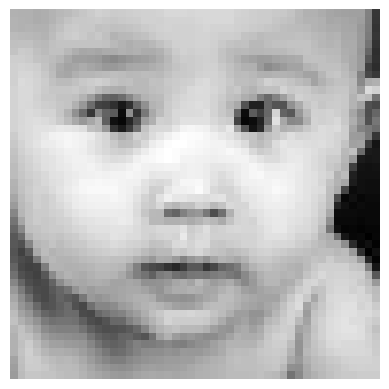

In [9]:
df= pd.DataFrame(dataf)
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(), dtype='float32'))
df['pixels'] = df['pixels'].apply(lambda x: np.reshape(x, (48, 48)))
df['pixels'] = df['pixels'] / 255.0
im = df['pixels'][0]
im
plt.imshow(im, cmap='gray')
plt.axis('off')

In [10]:
X = np.zeros(shape=(23705,48,48))
for i in range(len(df["pixels"])):
    X[i] = df["pixels"][i]
print(X.dtype)
print(X)

float64
[[[0.50588238 0.50196081 0.50196081 ... 0.4627451  0.3882353  0.20784314]
  [0.50980395 0.50588238 0.50196081 ... 0.45882353 0.38431373 0.20392157]
  [0.51372552 0.50588238 0.50980395 ... 0.44705883 0.38039216 0.19607843]
  ...
  [0.47450981 0.5411765  0.57647061 ... 0.59215689 0.58823532 0.58039218]
  [0.45882353 0.53725493 0.57254905 ... 0.58431375 0.58039218 0.58039218]
  [0.4509804  0.52941179 0.55686277 ... 0.57254905 0.57254905 0.57254905]]

 [[0.64313728 0.29019609 0.43529412 ... 0.43529412 0.43529412 0.40784314]
  [0.7019608  0.27450982 0.50196081 ... 0.43921569 0.44313726 0.42352942]
  [0.6901961  0.27843139 0.57254905 ... 0.43921569 0.43921569 0.42745098]
  ...
  [0.75294119 0.76862746 0.92156863 ... 0.43529412 0.48627451 0.43921569]
  [0.90196079 0.88627452 0.9137255  ... 0.7764706  0.77254903 0.70588237]
  [0.93333334 0.93725491 0.9137255  ... 0.71372551 0.66666669 0.58039218]]

 [[0.26274511 0.27450982 0.27843139 ... 0.77254903 0.76078433 0.75294119]
  [0.25490198 

In [11]:
ag = df['age']
ag=ag.astype(float)
ag= np.array(ag)
print(ag.shape)
print(ag)

(23705,)
[ 1.  1.  1. ... 99. 99. 99.]


In [12]:
g= df['gender']
g=np.array(g)
print(g.shape)
print(g)

(23705,)
[0 0 0 ... 1 1 1]


In [13]:
labels_f =[]
i=0
while i <len(ag):

  label=[]

  label.append([ag[i]])

  label.append([g[i]])

  labels_f.append(label)

  i+=1
labels_f =np.array(labels_f)
print(labels_f.shape)
print(labels_f)

(23705, 2, 1)
[[[ 1.]
  [ 0.]]

 [[ 1.]
  [ 0.]]

 [[ 1.]
  [ 0.]]

 ...

 [[99.]
  [ 1.]]

 [[99.]
  [ 1.]]

 [[99.]
  [ 1.]]]


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test= train_test_split(X,ag,test_size=0.25)

In [15]:
print(X_test.shape)

(5927, 48, 48)


In [16]:
print(X_train.shape)

(17778, 48, 48)


In [17]:
print(Y_test.shape)
print(Y_test)

(5927,)
[26. 31. 26. ... 41. 26. 26.]


In [18]:
print(Y_train.shape)
print(Y_train)

(17778,)
[31. 31. 25. ... 34. 30. 26.]


In [19]:
Y_train_2=[Y_train,Y_train]
Y_test_2=[Y_test,Y_test]
print(Y_train_2)
print(Y_test_2)

[array([31., 31., 25., ..., 34., 30., 26.]), array([31., 31., 25., ..., 34., 30., 26.])]
[array([26., 31., 26., ..., 41., 26., 26.]), array([26., 31., 26., ..., 41., 26., 26.])]


In [20]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [21]:
def Convolution(input_tensor,filters):
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1),kernel_regularizer=l2(0.001))(input_tensor)
    x = Dropout(0.1)(x)
    x= Activation('relu')(x)
    return x

In [22]:
def create_model(input_shape):
  inputs = Input((input_shape))
  conv_1= Convolution(inputs,32)
  maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
  conv_2 = Convolution(maxp_1,64)
  maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
  conv_3 = Convolution(maxp_2,128)
  maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
  conv_4 = Convolution(maxp_3,256)
  maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
  flatten= Flatten() (maxp_4)
  dense_1= Dense(64,activation='relu')(flatten)
  dense_2= Dense(64,activation='relu')(flatten)
  drop_1=Dropout(0.2)(dense_1)
  drop_2=Dropout(0.2)(dense_2)
  output_1= Dense(1,activation="sigmoid",name='sex_out')(drop_1)
  output_2= Dense(1,activation="relu",name='age_out')(drop_2)
  model = Model(inputs=[inputs], outputs=[output_1,output_2])
  model.compile(loss={"sex_out": "binary_crossentropy", "age_out": "mae"},
                  optimizer="Adam",
                  metrics={"sex_out": "accuracy"})
  return model

In [23]:
my_model=create_model(input_shape=(48,48,1))
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 32)           320       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 48, 48, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 activation (Activation)     (None, 48, 48, 32)           0         ['dropout[0][0]']             
                                                                                              

In [24]:
History = my_model.fit(X_train,Y_train_2,batch_size=64,validation_data=(X_test,Y_test_2),epochs=5)

Epoch 1/5
278/278 [==============================] - 146s 515ms/step - loss: -25896238972928.0000 - sex_out_loss: -25896238972928.0000 - age_out_loss: 35.1696 - sex_out_accuracy: 0.0478 - val_loss: -152143445098496.0000 - val_sex_out_loss: -152143445098496.0000 - val_age_out_loss: 33.4915 - val_sex_out_accuracy: 0.0459
Epoch 2/5
278/278 [==============================] - 134s 481ms/step - loss: -7252078585970688.0000 - sex_out_loss: -7252078585970688.0000 - age_out_loss: 33.2346 - sex_out_accuracy: 0.0479 - val_loss: -19519670730096640.0000 - val_sex_out_loss: -19519670730096640.0000 - val_age_out_loss: 33.4915 - val_sex_out_accuracy: 0.0459
Epoch 3/5
278/278 [==============================] - 136s 488ms/step - loss: -147722651366850560.0000 - sex_out_loss: -147722651366850560.0000 - age_out_loss: 33.2317 - sex_out_accuracy: 0.0479 - val_loss: -260189702907232256.0000 - val_sex_out_loss: -260189702907232256.0000 - val_age_out_loss: 33.4915 - val_sex_out_accuracy: 0.0459
Epoch 4/5
278/2

In [25]:
my_model.evaluate(X_test,Y_test_2)

186/186 [==============================] - 8s 44ms/step - loss: -5257760700176007168.0000 - sex_out_loss: -5257760700176007168.0000 - age_out_loss: 33.4915 - sex_out_accuracy: 0.0459


[-5.257760700176007e+18,
 -5.257760700176007e+18,
 33.491477966308594,
 0.04589168354868889]

In [27]:
pred=my_model.predict(X_test)
pred[1]

186/186 [==============================] - 13s 66ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

1/1 [==============================] - 0s 42ms/step
Predicted Age: 0
Predicted Sex: Male


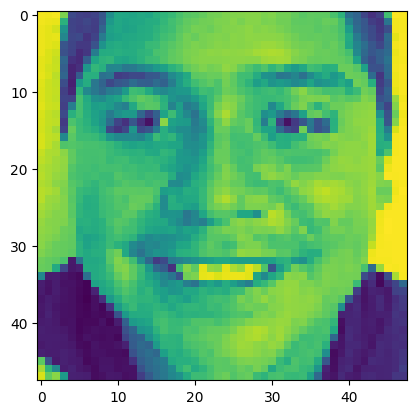

In [30]:
def test_image(ind,X,Model):

  plt.imshow(X[ind])

  image_test=X[ind]

  pred_1=my_model.predict(np.array([image_test]))

  sex_f=['Female','Male']

  age=int(np.round(pred_1[1][0]))

  sex=int(np.round(pred_1[0][0]))

  print("Predicted Age: "+ str(age))

  print("Predicted Sex: "+ sex_f[sex])

test_image(1900,X, Model)